Import Libraries

In [27]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import savgol_filter

User Input - Fuel of choice to be forecasted

In [28]:
fuel = 'Solar'

Loading Data

In [29]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = [str(2017 + i) for i in range(7)]
fuel_type = ['Biomass','Coal','Gas','Gas-CC','Hydro','Nuclear','Other','Solar','Wind']
date_range = pandas.date_range(start='01-01-2017', end='06-30-2023')
data = {year: {month: pandas.read_excel(f'IntGenbyFuel{year}.xlsx',sheet_name=month) for month in months} for year in years}
df = pandas.concat(data[year][month] for year in years for month in months)
filtered_df = df[(df['Fuel'] == fuel) & (df['Date'].isin(date_range))]
columns =['Date','Fuel'] + [f'{i}:{j:02d}' for i in range(0,24) for j in range(0,60,15)]
filtered_df = filtered_df[columns]
k3 = pandas.DataFrame(columns=[filtered_df.columns[0], 'Timestamp', filtered_df.columns[1],'Values'])

for i in range(filtered_df.shape[0]):
    k2 = filtered_df.iloc[i, :]
    row = pandas.DataFrame(np.zeros((96, 98)), columns=k2.index)
    row.iloc[:, :2] = k2[k2.index[:2]].values
    row['Timestamp'] = k2.index[2:]
    row['Values'] = k2.values[2:]
    k3 = pandas.concat([k3, row.loc[:, [k2.index[0],'Timestamp',k2.index[1],  'Values']]], ignore_index=True)

k3['Datetime'] = pandas.to_datetime(k3['Date'].astype(str) + ' ' + k3['Timestamp'].astype(str))
k3 = k3.drop(['Date', 'Timestamp'], axis=1)
k3 = k3.set_index('Datetime')

print(k3)

                      Fuel    Values
Datetime                            
2017-01-01 00:00:00  Solar       0.0
2017-01-01 00:15:00  Solar       0.0
2017-01-01 00:30:00  Solar       0.0
2017-01-01 00:45:00  Solar       0.0
2017-01-01 01:00:00  Solar       0.0
...                    ...       ...
2023-06-30 22:45:00  Solar  0.000108
2023-06-30 23:00:00  Solar   0.00012
2023-06-30 23:15:00  Solar  0.000108
2023-06-30 23:30:00  Solar  0.000706
2023-06-30 23:45:00  Solar  0.000108

[227712 rows x 2 columns]


In [30]:
dt = k3
dt = dt.dropna()
dt = dt.resample('D').mean()
dt

C:\Users\Dell\AppData\Local\Temp\ipykernel_13684\1939628220.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  dt = dt.resample('D').mean()


,Values
Datetime,
2017-01-01,36.452932
2017-01-02,37.855706
2017-01-03,33.566083
2017-01-04,25.525637
2017-01-05,25.186064
...,...
2023-06-26,1390.549971
2023-06-27,1403.804343
2023-06-28,1260.095162


<AxesSubplot:xlabel='Datetime'>

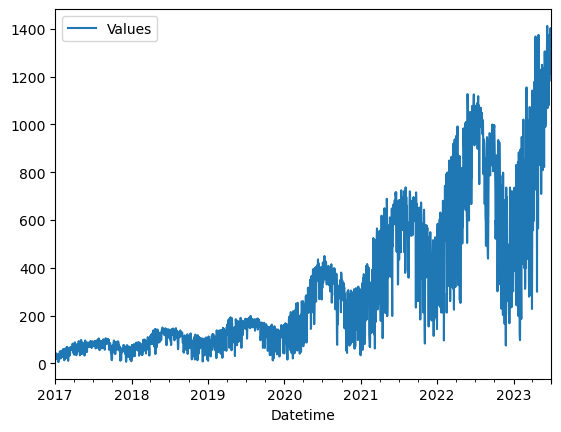

In [31]:
dt.plot()

Seasonality breakdown

In [32]:
decomposition = seasonal_decompose(dt['Values'],period=12,model='additive')

trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

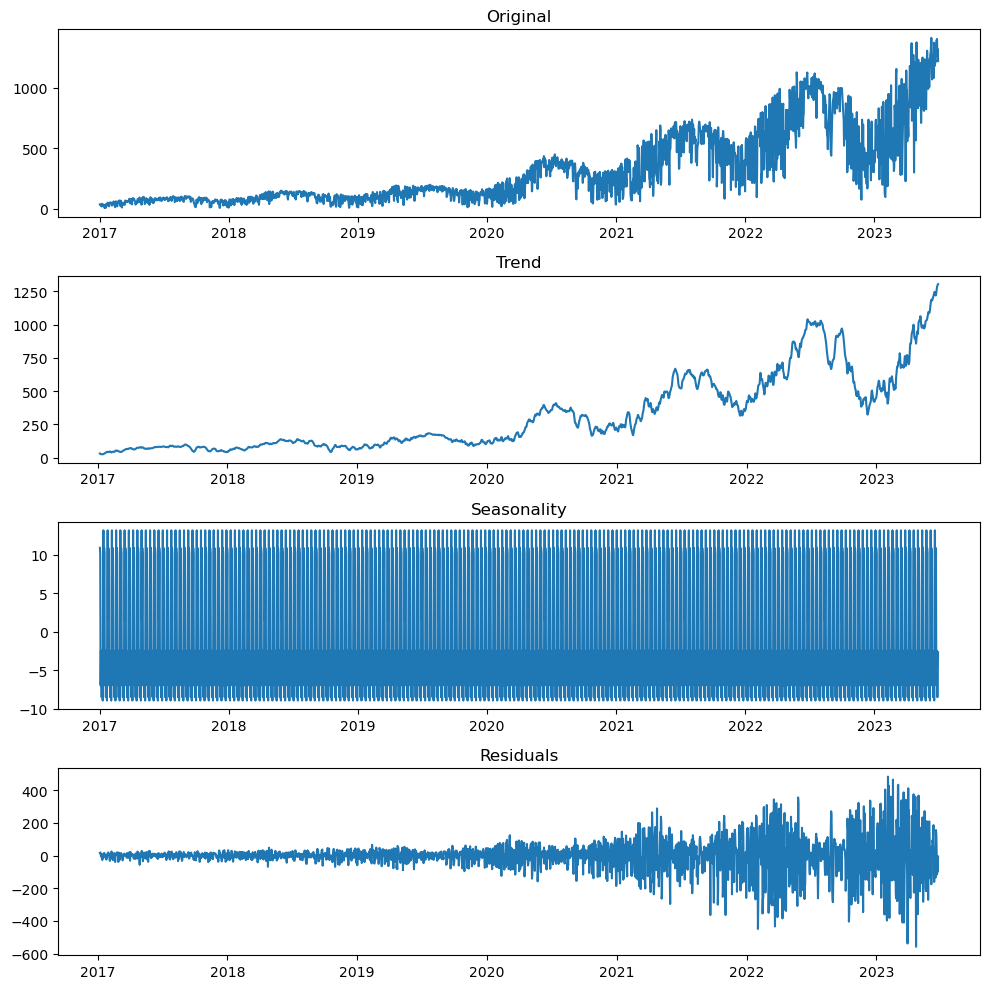

In [33]:
fig, axs = plt.subplots(4, 1, figsize=(10,10))

axs[0].plot(dt['Values'])
axs[0].set_title('Original')
axs[1].plot(trend)
axs[1].set_title('Trend')
axs[2].plot(seasonal)
axs[2].set_title('Seasonality')
axs[3].plot(residual)
axs[3].set_title('Residuals')

plt.tight_layout()
plt.show()

Data Processing

In [34]:
window_size = 50
polynomial_degree = 2
smoothed_data = savgol_filter(dt['Values'], window_size, polynomial_degree)
start = '2017-01-01'
end = '2023-06-30'
dates = pandas.date_range(start=start, end=end)
filtered_data = pandas.DataFrame(smoothed_data, index=dates, columns=['Values'])
filtered_data = np.log(filtered_data)

In [35]:
train_df=filtered_data['Values'].iloc[:-334]
test_df=filtered_data['Values'].iloc[-334:]
print(train_df.shape,test_df.shape)

(2038,) (334,)


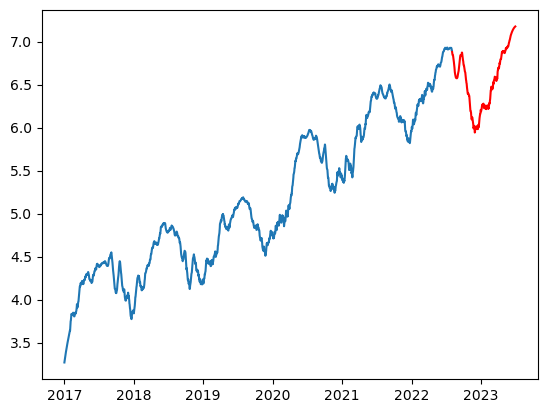

In [36]:
plt.plot(test_df, color = 'red')
plt.plot(train_df)

Spliting Data - Training & Testing

In [37]:
train = [i for i in train_df]
test = [i for i in test_df]

ARIMA best Model fit

In [38]:
stepwise_fit = auto_arima(train, trace=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-11891.949, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-11187.890, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-11849.170, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-11688.271, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-11163.120, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-11896.201, Time=2.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-11808.375, Time=2.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-11853.139, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-11897.754, Time=3.76 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-11814.495, Time=3.03 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-11902.664, Time=3.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-11923.374, Time=1.34 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-11898.563, Time=1.42 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-11929.713, Time=5.51 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2038
Model:               SARIMAX(4, 1, 3)   Log Likelihood                5973.856
Date:                Sun, 10 Mar 2024   AIC                         -11929.713
Time:                        22:37:58   BIC                         -11879.140
Sample:                             0   HQIC                        -11911.160
                               - 2038                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.611      0.107   -5.78e-05       0.001
ar.L1          1.0248      0.090     11.449      0.000       0.849       1.200
ar.L2         -0.8612      0.116     -7.396      0.000      -1.089      -0.633
ar.L3          0.8198      0.107      7.684      0.000       0.611       1.029
ar.L4         -0.1356      0.051     -2.641      0.008      -0.236      -0.035
ma.L1         -0.5411      0.085     -6.337      0.000      -0.709      -0.374
ma.L2          0.6149      0.077      7.943      0.000       0.463       0.767
ma.L3         -0.5482      0.071     -7.678      0.000      -0.688      -0.408
sigma2         0.0002   4.46e-06     37.124      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                55.46
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Rolling Horizon Technique

In [39]:
history = train
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(4,1,3)) # choose best fitting model
    model_fit = model.fit() # great a model fit
    output = model_fit.forecast() # forecast for chosen data 
    yhat = output[0] 
    predictions.append(yhat) #storing yhat
    obs = test[t] 
    history.append(obs)

C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\

C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\

C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Dell\anaconda3\envs\HBS\lib\site-packages\statsmodels\base\

Predicting Using Trianed model

In [40]:
predictions_df = pandas.DataFrame(predictions,index = test_df.index,columns = ['Values'] )
test_df = pandas.DataFrame(test_df ,columns = ['Values'])

In [41]:
predictions_df,test_df

(              Values
 2022-08-01  6.897433
 2022-08-02  6.884567
 2022-08-03  6.866621
 2022-08-04  6.845451
 2022-08-05  6.838987
 ...              ...
 2023-06-26  7.167364
 2023-06-27  7.169903
 2023-06-28  7.172231
 2023-06-29  7.174359
 2023-06-30  7.176289
 
 [334 rows x 1 columns],
               Values
 2022-08-01  6.890525
 2022-08-02  6.875367
 2022-08-03  6.856473
 2022-08-04  6.845827
 2022-08-05  6.845489
 ...              ...
 2023-06-26  7.167662
 2023-06-27  7.170145
 2023-06-28  7.172425
 2023-06-29  7.174504
 2023-06-30  7.176382
 
 [334 rows x 1 columns])

In [42]:
from matplotlib import rc

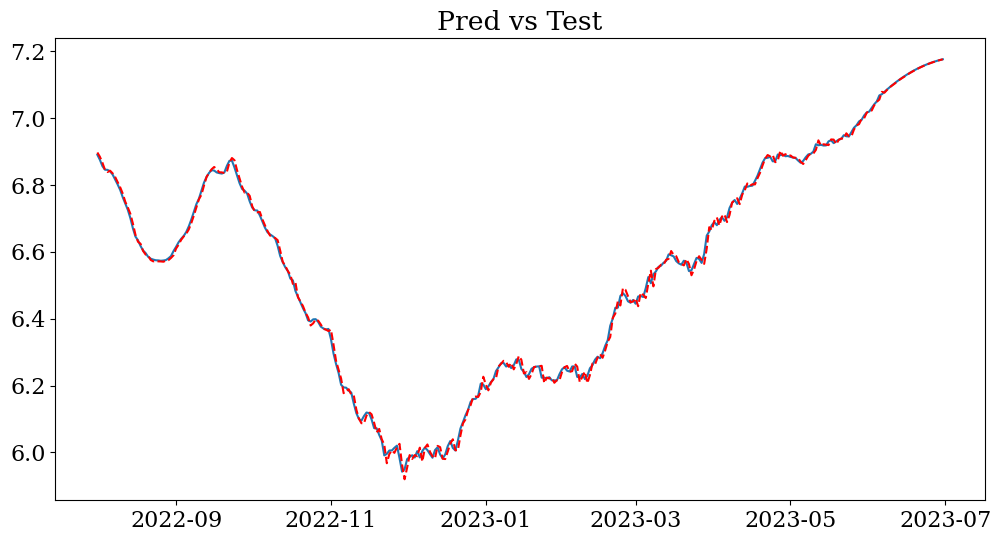

In [43]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(test_df)
ax.plot(predictions_df, linestyle = '--', color = 'red')
plt.title('Pred vs Test')
plt.rcdefaults()

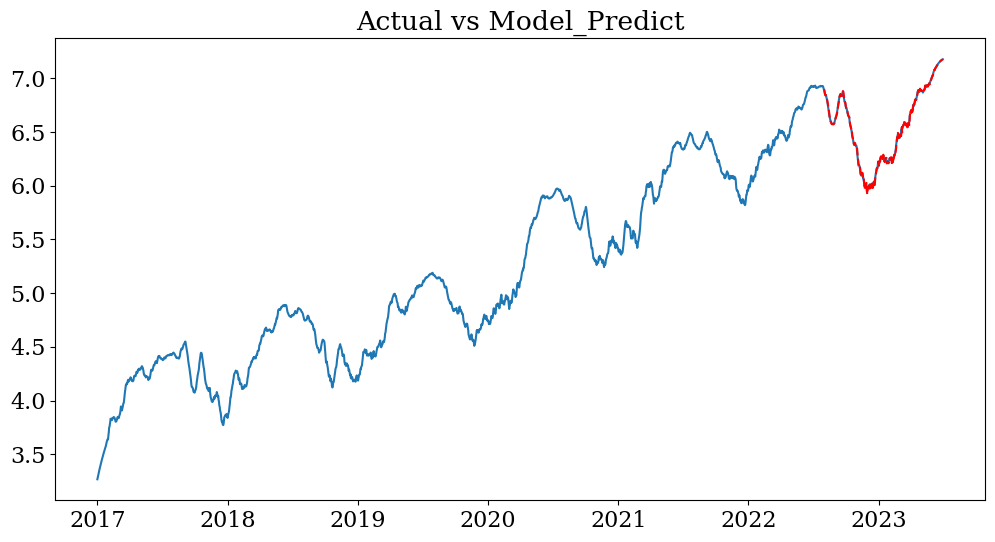

In [45]:
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 16})
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(filtered_data)
ax.plot(predictions_df, linestyle = '--', color = 'red')
plt.title('Actual vs Model_Predict')
plt.rcdefaults()

In [46]:
from sklearn.metrics import mean_squared_error

Model Validation

In [47]:
rmse = np.sqrt(mean_squared_error(test_df, predictions_df))
print(f"RMSE: {rmse}")

RMSE: 0.012685221406320769
